**EMBEDDING**

Required library


In [1]:
!pip install transformers


code


In [ ]:
!pip install transformers torch pandas tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 869.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# Load your Malayalam review dataset
df = pd.read_excel("/content/Malayalam_Reviews_1500Fake_1400Real (1).xlsx").dropna()
texts = df['Review'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()

# Load IndicBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
model = AutoModel.from_pretrained("ai4bharat/indic-bert")
model.eval()  # Set to inference mode

# Function to get [CLS] embedding for a sentence
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

# Loop through all reviews and embed
embeddings = []
for text in tqdm(texts, desc="Embedding Reviews"):
    try:
        emb = get_cls_embedding(text)
        embeddings.append(emb)
    except Exception as e:
        print(f"Error embedding: {text[:30]}... → {e}")
        embeddings.append([0]*768)  # fallback zero vector

# Convert to DataFrame and save
embeddings_df = pd.DataFrame(embeddings)
embeddings_df['Label'] = labels
embeddings_df.to_csv("IndicBERT_Malayalam_Embeddings.csv", index=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Embedding Reviews:   0%|          | 1/2900 [00:00<30:30,  1.58it/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Embedding Reviews: 100%|██████████| 2900/2900 [15:01<00:00,  3.22it/s]


**Combining both malayalam reviews and Embedding dataset**

In [ ]:
import pandas as pd

# Step 1: Load both datasets
# - Embedded dataset (768 features + Label)
# - Original dataset (Review + Label)
embeddings_df = pd.read_csv("/content/IndicBERT_Malayalam_Embeddings.csv")
reviews_df = pd.read_excel("/content/Malayalam_Review_Label_Only.xlsx")  # or .csv if needed

# Step 2: Ensure both are aligned by index
# (Assumes both datasets are in the same order and row count)
assert len(embeddings_df) == len(reviews_df), "Datasets do not match in size."

# Step 3: Add Review column to embeddings dataframe
embeddings_df["Review"] = reviews_df["Review"]

# Step 4: Optional – move 'Review' and 'Label' to the front
cols = ["Review", "Label"] + [col for col in embeddings_df.columns if col not in ["Review", "Label"]]
final_df = embeddings_df[cols]

# Step 5: Save to new file
final_df.to_excel("IndicBERT_Embeddings_With_Review.xlsx", index=False)
# Or use .to_csv(...) if preferred

print("✅ Review column successfully added and saved!")


✅ Review column successfully added and saved!


**Applying Machiene Learning Models**

In [ ]:
!pip install pandas scikit-learn


**Random Forest**

🌲 Random Forest Results
Train Accuracy: 0.8502125531382846
Test Accuracy: 0.627
Train F1 Score: 0.9004156275976725
Test F1 Score: 0.7573194534808068


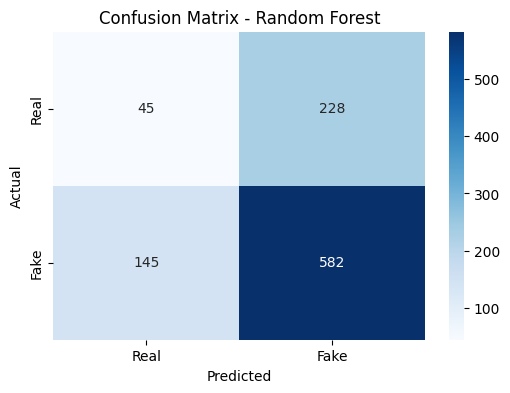

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 1: Set your file path here
file_path = "/content/IndicBERT_Embeddings_With_Review.xlsx"  # Change this

# STEP 2: Load Excel/CSV
if file_path.endswith(".xlsx"):
    df = pd.read_excel(file_path, engine='openpyxl')
elif file_path.endswith(".csv"):
    df = pd.read_csv(file_path)
else:
    raise ValueError("Unsupported file format. Use .xlsx or .csv")

# STEP 3: Drop 'Review' column if present
df = df.drop(columns=['Review'], errors='ignore')

# STEP 4: Clean Label
df = df.dropna(subset=['Label'])
df['Label'] = df['Label'].astype(int)

# STEP 5: Prepare features
X = df.drop(columns=['Label']).apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['Label']

# STEP 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 7: Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# STEP 8: Evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(" Random Forest Results")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Test F1 Score:", f1_score(y_test, y_test_pred))

# STEP 9: Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**AdaBoost**


🚀 AdaBoost
Train Accuracy: 0.7284321080270068
Test Accuracy: 0.729
Train F1 Score: 0.8398702447655558
Test F1 Score: 0.8414277355178467


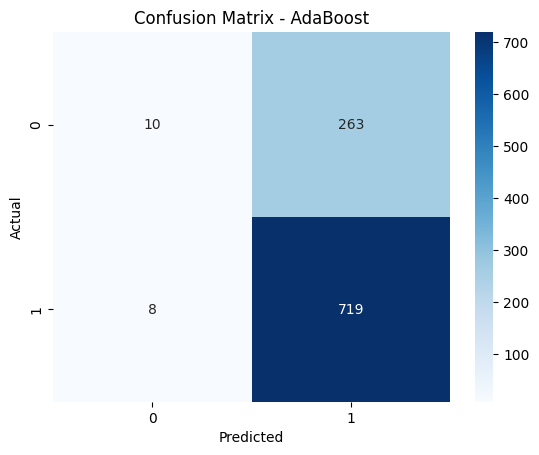

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

# Set your dataset path
file_path = "/content/IndicBERT_Embeddings_With_Review.xlsx"  # change this

# Load dataset
if file_path.endswith(".xlsx"):
    df = pd.read_excel(file_path, engine='openpyxl')
elif file_path.endswith(".csv"):
    df = pd.read_csv(file_path)
else:
    raise ValueError("Unsupported file format. Use .xlsx or .csv")

# Clean data
df = df.drop(columns=['Review'], errors='ignore')
df = df.dropna(subset=['Label'])
df['Label'] = df['Label'].astype(int)
X = df.drop(columns=['Label']).apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualization function
def show_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



model = AdaBoostClassifier(random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("\n AdaBoost")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Test F1 Score:", f1_score(y_test, y_test_pred))

show_confusion_matrix(y_test, y_test_pred, "AdaBoost")


**XGBoost**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:47:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



⚡ XGBoost
Train Accuracy: 0.8502125531382846
Test Accuracy: 0.623
Train F1 Score: 0.9009426161733091
Test F1 Score: 0.7534336167429693


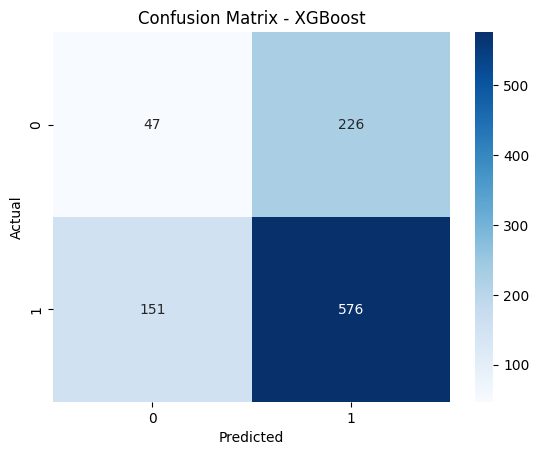

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Set your dataset path
file_path = "/content/IndicBERT_Embeddings_With_Review.xlsx"  # change this

# Load dataset
if file_path.endswith(".xlsx"):
    df = pd.read_excel(file_path, engine='openpyxl')
elif file_path.endswith(".csv"):
    df = pd.read_csv(file_path)
else:
    raise ValueError("Unsupported file format. Use .xlsx or .csv")

# Clean data
df = df.drop(columns=['Review'], errors='ignore')
df = df.dropna(subset=['Label'])
df['Label'] = df['Label'].astype(int)
X = df.drop(columns=['Label']).apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualization function
def show_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("\n XGBoost")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Test F1 Score:", f1_score(y_test, y_test_pred))

show_confusion_matrix(y_test, y_test_pred, "XGBoost")


**CatBoost**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00



🐱 CatBoost
Train Accuracy: 0.8289572393098275
Test Accuracy: 0.664
Train F1 Score: 0.8915318744053282
Test F1 Score: 0.7897371714643304


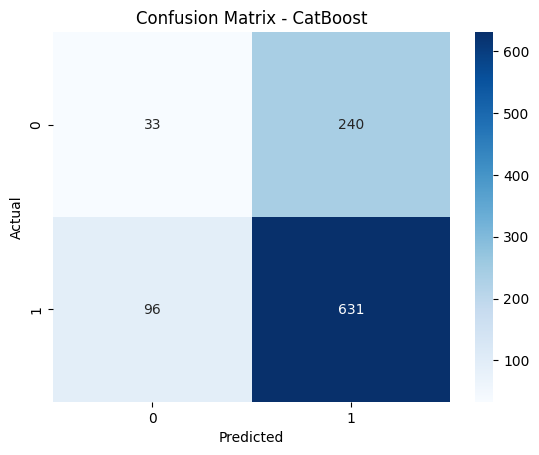

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

# Set your dataset path
file_path = "/content/IndicBERT_Embeddings_With_Review.xlsx"  # change this

# Load dataset
if file_path.endswith(".xlsx"):
    df = pd.read_excel(file_path, engine='openpyxl')
elif file_path.endswith(".csv"):
    df = pd.read_csv(file_path)
else:
    raise ValueError("Unsupported file format. Use .xlsx or .csv")

# Clean data
df = df.drop(columns=['Review'], errors='ignore')
df = df.dropna(subset=['Label'])
df['Label'] = df['Label'].astype(int)
X = df.drop(columns=['Label']).apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualization function
def show_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("\n CatBoost")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Test F1 Score:", f1_score(y_test, y_test_pred))

show_confusion_matrix(y_test, y_test_pred, "CatBoost")


**Naive Bayes**


📊 Naive Bayes
Train Accuracy: 0.6569142285571393
Test Accuracy: 0.652
Train F1 Score: 0.7581100141043724
Test F1 Score: 0.7573221757322176


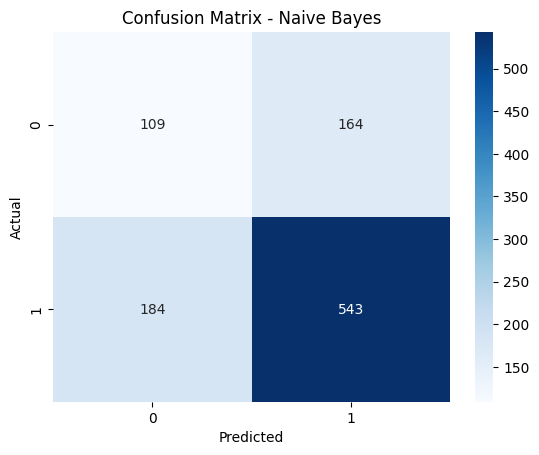

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

# Set your dataset path
file_path = "/content/IndicBERT_Embeddings_With_Review.xlsx"  # change this

# Load dataset
if file_path.endswith(".xlsx"):
    df = pd.read_excel(file_path, engine='openpyxl')
elif file_path.endswith(".csv"):
    df = pd.read_csv(file_path)
else:
    raise ValueError("Unsupported file format. Use .xlsx or .csv")

# Clean data
df = df.drop(columns=['Review'], errors='ignore')
df = df.dropna(subset=['Label'])
df['Label'] = df['Label'].astype(int)
X = df.drop(columns=['Label']).apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualization function
def show_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



model = GaussianNB()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("\n Naive Bayes")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Test F1 Score:", f1_score(y_test, y_test_pred))

show_confusion_matrix(y_test, y_test_pred, "Naive Bayes")


**MLP (Neural Network)**


🧠 MLP Neural Net
Train Accuracy: 0.7396849212303076
Test Accuracy: 0.719
Train F1 Score: 0.8397228637413395
Test F1 Score: 0.8277130594727161


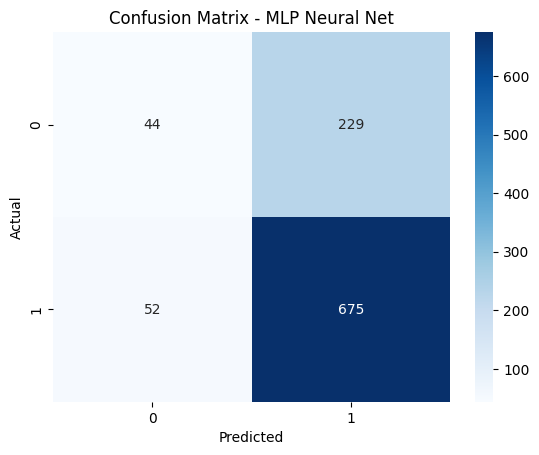

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
# 🔁 Set your dataset path
file_path = "/content/IndicBERT_Embeddings_With_Review.xlsx"  # change this

# Load dataset
if file_path.endswith(".xlsx"):
    df = pd.read_excel(file_path, engine='openpyxl')
elif file_path.endswith(".csv"):
    df = pd.read_csv(file_path)
else:
    raise ValueError("Unsupported file format. Use .xlsx or .csv")

# Clean data
df = df.drop(columns=['Review'], errors='ignore')
df = df.dropna(subset=['Label'])
df['Label'] = df['Label'].astype(int)
X = df.drop(columns=['Label']).apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualization function
def show_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



model = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("\n MLP Neural Net")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Test F1 Score:", f1_score(y_test, y_test_pred))

show_confusion_matrix(y_test, y_test_pred, "MLP Neural Net")



PCA BASED

In [ ]:
!pip install xgboost catboost imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


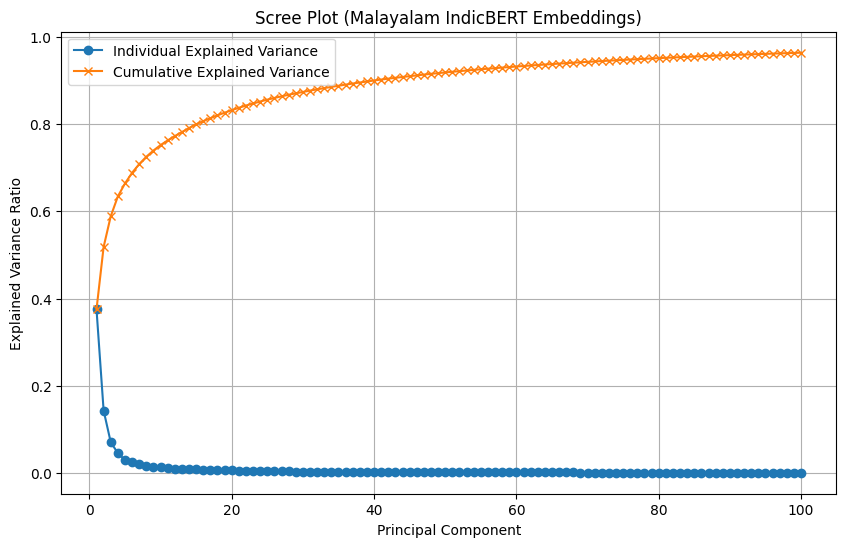

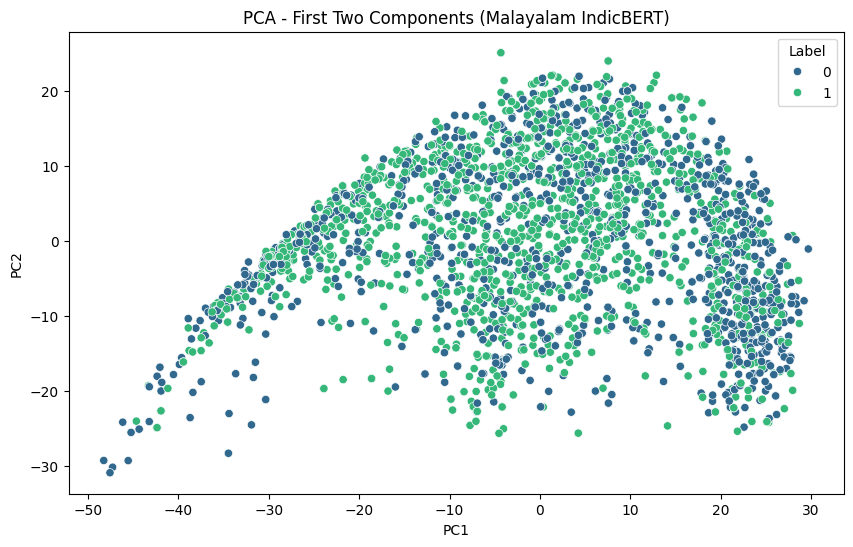

In [15]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# === Load dataset ===
file_path = "/content/IndicBERT_Malayalam_Embeddings.csv"
df = pd.read_csv(file_path)

# === Handle NaNs by filling with mean ===
df.fillna(df.mean(numeric_only=True), inplace=True)

# === Features and Labels ===
X = df.drop(columns=['Label'])
y = df['Label']

# === Standardize Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Apply PCA (100 components) ===
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

# === Explained Variance ===
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# === Scree Plot ===
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), explained_variance, marker='o', label='Individual Explained Variance')
plt.plot(range(1, 101), cumulative_variance, marker='x', label='Cumulative Explained Variance')
plt.title("Scree Plot (Malayalam IndicBERT Embeddings)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.grid(True)
plt.savefig("malayalam_laser_scree_plot.png")
plt.show()

# === PCA 2D Scatter Plot ===
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
plt.title("PCA - First Two Components (Malayalam IndicBERT)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("malayalam_laser_pca_scatter.png")
plt.show()

# === Save PCA-transformed data ===
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(100)])
pca_df['Label'] = y.values
pca_df.to_csv("LASER_Malayalam_PCA100.csv", index=False)

# === Save explained variance ===
pd.DataFrame({
    'Component': range(1, 101),
    'Explained Variance Ratio': explained_variance,
    'Cumulative Variance Ratio': cumulative_variance
}).to_csv("LASER_Malayalam_PCA_Variance.csv", index=False)


# **After PCA**

RANDOM FOREST

Initial dataset shape: (2900, 769)
NaN values in dataset: 0 total NaN values
NaN values in Label column: 0
Dataset shape after dropping NaN values: (2900, 769)
Data loading completed in 1.22 seconds
Number of components selected: 50
Explained variance ratio: 0.9190
PCA completed in 2.84 seconds
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 203}
Best cross-validation score: 0.5435354274819963
Hyperparameter tuning completed in 126.15 seconds

Training Accuracy: 0.8875
Test Accuracy: 0.5344827586206896

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.52      0.46      0.49       280
           1       0.55      0.60      0.57       300

    accuracy                           0.53       580
   macro avg       0.53      0.53      0.53       580
weighted avg       0.53      0.53      0.53    

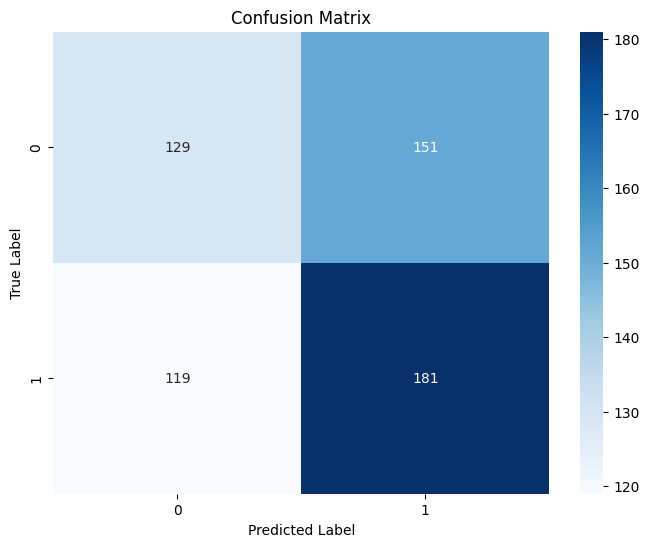

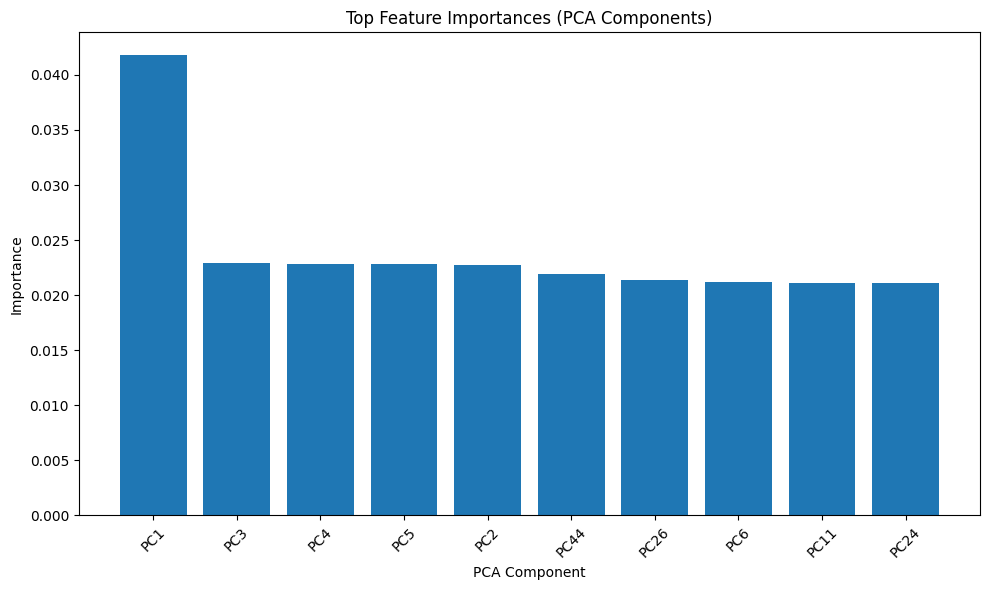

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import time
from scipy.stats import randint, uniform

# Setting random seed for reproducibility
np.random.seed(42)

# Loading and cleaning the dataset
def load_data():
    start_time = time.time()
    df = pd.read_csv('/content/IndicBERT_Malayalam_Embeddings.csv')

    # Checking for NaN values
    print(f"Initial dataset shape: {df.shape}")
    print(f"NaN values in dataset: {df.isna().sum().sum()} total NaN values")
    print(f"NaN values in Label column: {df['Label'].isna().sum()}")

    # Dropping rows with NaN values
    df_clean = df.dropna()
    print(f"Dataset shape after dropping NaN values: {df_clean.shape}")

    X = df_clean.drop('Label', axis=1)
    y = df_clean['Label']

    print(f"Data loading completed in {time.time() - start_time:.2f} seconds")
    return X, y

# Applying PCA for dimensionality reduction
def apply_pca(X_train, X_test, n_components=50):  # Fixed number of components for speed
    start_time = time.time()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"Number of components selected: {pca.n_components_}")
    print(f"Explained variance ratio: {explained_variance:.4f}")
    print(f"PCA completed in {time.time() - start_time:.2f} seconds")

    return X_train_pca, X_test_pca, pca

# Performing hyperparameter tuning for Random Forest
def tune_random_forest(X_train, y_train):
    start_time = time.time()
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)

    param_dist = {
        'n_estimators': randint(100, 300),
        'max_depth': [10, 20, None],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2']
    }

    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        n_jobs=-1,
        scoring='accuracy',
        verbose=1,
        random_state=42
    )

    random_search.fit(X_train, y_train)

    print("\nBest parameters:", random_search.best_params_)
    print("Best cross-validation score:", random_search.best_score_)
    print(f"Hyperparameter tuning completed in {time.time() - start_time:.2f} seconds")

    return random_search.best_estimator_

# Evaluating the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print("\nTraining Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_rf.png')

    print(f"Model evaluation completed in {time.time() - start_time:.2f} seconds")
    return train_accuracy, test_accuracy

# Visualizing feature importance
def plot_feature_importance(model, pca, n_features=10):
    start_time = time.time()
    importances = model.feature_importances_
    feature_names = [f'PC{i+1}' for i in range(len(importances))]
    indices = np.argsort(importances)[::-1][:n_features]

    plt.figure(figsize=(10, 6))
    plt.bar(range(n_features), importances[indices])
    plt.xticks(range(n_features), [feature_names[i] for i in indices], rotation=45)
    plt.title('Top Feature Importances (PCA Components)')
    plt.xlabel('PCA Component')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importance_rf.png')

    print(f"Feature importance plotting completed in {time.time() - start_time:.2f} seconds")

# Main execution
def main():
    start_time = time.time()
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test)
    best_rf = tune_random_forest(X_train_pca, y_train)
    train_acc, test_acc = evaluate_model(best_rf, X_train_pca, X_test_pca, y_train, y_test)
    plot_feature_importance(best_rf, pca)

    if test_acc >= 0.80:
        print("\nSuccess: Model achieved accuracy >= 80%")
    else:
        print("\nWarning: Model accuracy below 80%. Consider trying different parameters or models.")

    import joblib
    model_id = str(uuid.uuid4())
    joblib.dump(best_rf, f'rf_model_{model_id}.pkl')
    print(f"\nModel saved as rf_model_{model_id}.pkl")
    print(f"Total execution time: {time.time() - start_time:.2f} seconds")

if __name__ == "__main__":
    main()

XGBoost

Initial dataset shape: (2900, 769)
NaN values in dataset: 0 total NaN values
NaN values in Label column: 0
Dataset shape after dropping NaN values: (2900, 769)
Data loading completed in 0.89 seconds
Number of components selected: 50
Explained variance ratio: 0.9190
PCA completed in 2.47 seconds
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'colsample_bytree': np.float64(0.662397808134481), 'learning_rate': np.float64(0.026844247528777843), 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 203, 'subsample': np.float64(0.8832290311184181)}
Best cross-validation score: 0.523280884904279
Hyperparameter tuning completed in 70.07 seconds

Training Accuracy: 0.8836206896551724
Test Accuracy: 0.5362068965517242

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.52      0.47      0.50       280
           1       0.55      0.59      0.57       300

    accuracy                           0.54      

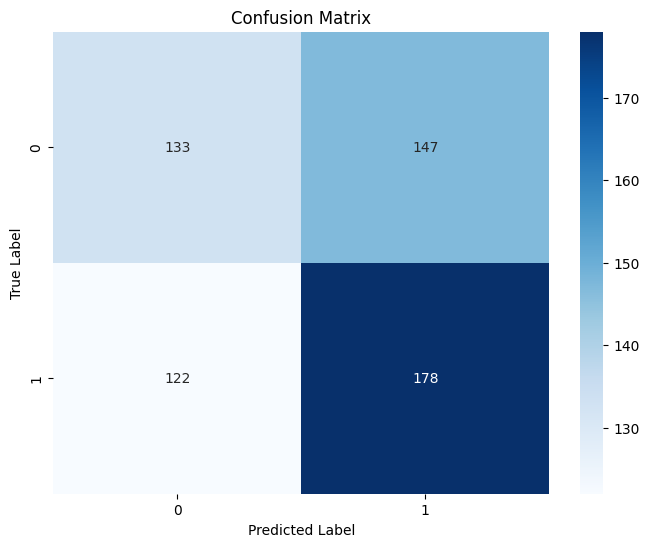

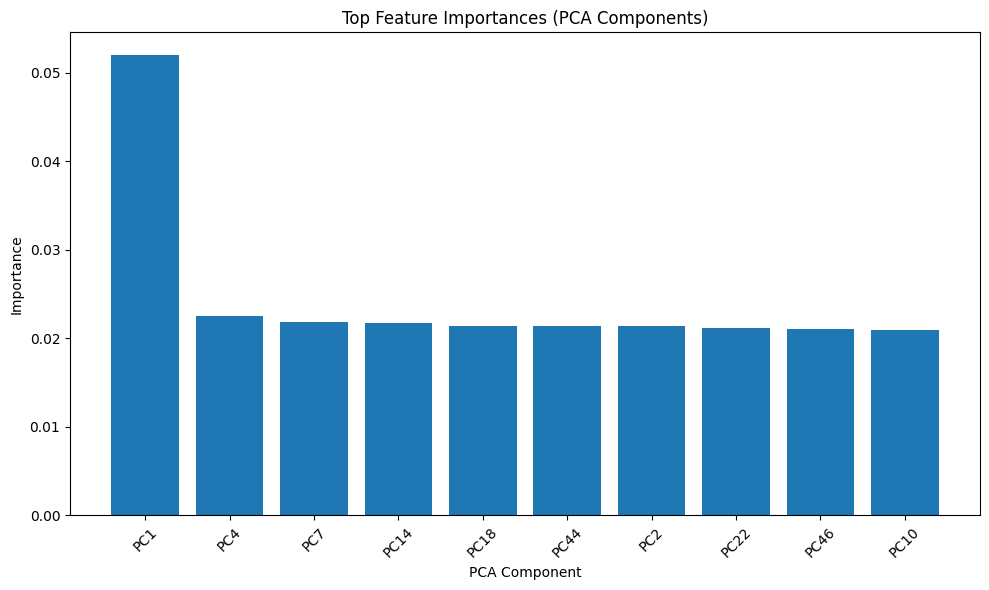

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import time
from scipy.stats import randint, uniform

# Setting random seed for reproducibility
np.random.seed(42)

# Loading and cleaning the dataset
def load_data():
    start_time = time.time()
    df = pd.read_csv('/content/IndicBERT_Malayalam_Embeddings.csv')

    print(f"Initial dataset shape: {df.shape}")
    print(f"NaN values in dataset: {df.isna().sum().sum()} total NaN values")
    print(f"NaN values in Label column: {df['Label'].isna().sum()}")

    df_clean = df.dropna()
    print(f"Dataset shape after dropping NaN values: {df_clean.shape}")

    X = df_clean.drop('Label', axis=1)
    y = df_clean['Label']

    print(f"Data loading completed in {time.time() - start_time:.2f} seconds")
    return X, y

# Applying PCA for dimensionality reduction
def apply_pca(X_train, X_test, n_components=50):
    start_time = time.time()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"Number of components selected: {pca.n_components_}")
    print(f"Explained variance ratio: {explained_variance:.4f}")
    print(f"PCA completed in {time.time() - start_time:.2f} seconds")

    return X_train_pca, X_test_pca, pca

# Performing hyperparameter tuning for XGBoost
def tune_xgboost(X_train, y_train):
    start_time = time.time()
    xgb = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')

    param_dist = {
        'n_estimators': randint(100, 300),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.29),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'min_child_weight': randint(1, 6)
    }

    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        n_jobs=-1,
        scoring='accuracy',
        verbose=1,
        random_state=42
    )

    random_search.fit(X_train, y_train)

    print("\nBest parameters:", random_search.best_params_)
    print("Best cross-validation score:", random_search.best_score_)
    print(f"Hyperparameter tuning completed in {time.time() - start_time:.2f} seconds")

    return random_search.best_estimator_

# Evaluating the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print("\nTraining Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_xgboost.png')

    print(f"Model evaluation completed in {time.time() - start_time:.2f} seconds")
    return train_accuracy, test_accuracy

# Visualizing feature importance
def plot_feature_importance(model, pca, n_features=10):
    start_time = time.time()
    importances = model.feature_importances_
    feature_names = [f'PC{i+1}' for i in range(len(importances))]
    indices = np.argsort(importances)[::-1][:n_features]

    plt.figure(figsize=(10, 6))
    plt.bar(range(n_features), importances[indices])
    plt.xticks(range(n_features), [feature_names[i] for i in indices], rotation=45)
    plt.title('Top Feature Importances (PCA Components)')
    plt.xlabel('PCA Component')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importance_xgboost.png')

    print(f"Feature importance plotting completed in {time.time() - start_time:.2f} seconds")

# Main execution
def main():
    start_time = time.time()
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test)
    best_xgb = tune_xgboost(X_train_pca, y_train)
    train_acc, test_acc = evaluate_model(best_xgb, X_train_pca, X_test_pca, y_train, y_test)
    plot_feature_importance(best_xgb, pca)

    if test_acc >= 0.80:
        print("\nSuccess: Model achieved accuracy >= 80%")
    else:
        print("\nWarning: Model accuracy below 80%. Consider trying different parameters or models.")

    import joblib
    model_id = str(uuid.uuid4())
    joblib.dump(best_xgb, f'xgb_model_{model_id}.pkl')
    print(f"\nModel saved as xgb_model_{model_id}.pkl")
    print(f"Total execution time: {time.time() - start_time:.2f} seconds")

if __name__ == "__main__":
    main()

MLP

Initial dataset shape: (2900, 769)
NaN values in dataset: 0 total NaN values
NaN values in Label column: 0
Dataset shape after dropping NaN values: (2900, 769)
Data loading completed in 1.11 seconds
Number of components selected: 50
Explained variance ratio: 0.9190
PCA completed in 2.32 seconds
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Best parameters: {'activation': 'tanh', 'alpha': np.float64(0.001514381497427214), 'batch_size': 162, 'hidden_layer_sizes': (100,), 'learning_rate_init': np.float64(0.0006584746323682926), 'solver': 'sgd'}
Best cross-validation score: 0.5254297439531652
Hyperparameter tuning completed in 172.45 seconds

Training Accuracy: 0.7982758620689655
Test Accuracy: 0.5189655172413793

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.50      0.49      0.50       280
           1       0.53      0.54      0.54       300

    accuracy                           0.52       580
   macro avg       0.52      0.52      0.52       580
weighted avg       0.52      0.52      0.52       580

Model evaluation completed in 0.22 seconds


Model saved as mlp_model_e78df066-e0dd-45a0-ade1-fb8a277bb0b6.pkl
Total execution time: 176.13 seconds


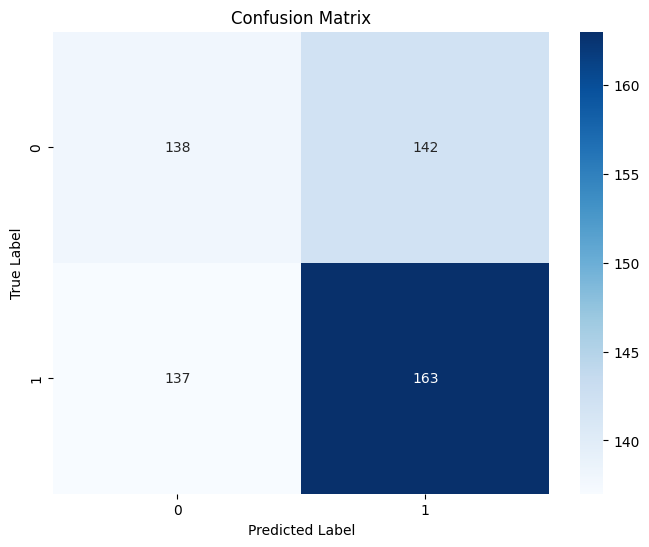

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import time
from scipy.stats import randint, uniform

# Setting random seed for reproducibility
np.random.seed(42)

# Loading and cleaning the dataset
def load_data():
    start_time = time.time()
    df = pd.read_csv('/content/IndicBERT_Malayalam_Embeddings.csv')

    print(f"Initial dataset shape: {df.shape}")
    print(f"NaN values in dataset: {df.isna().sum().sum()} total NaN values")
    print(f"NaN values in Label column: {df['Label'].isna().sum()}")

    df_clean = df.dropna()
    print(f"Dataset shape after dropping NaN values: {df_clean.shape}")

    X = df_clean.drop('Label', axis=1)
    y = df_clean['Label']

    print(f"Data loading completed in {time.time() - start_time:.2f} seconds")
    return X, y

# Applying PCA for dimensionality reduction
def apply_pca(X_train, X_test, n_components=50):
    start_time = time.time()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"Number of components selected: {pca.n_components_}")
    print(f"Explained variance ratio: {explained_variance:.4f}")
    print(f"PCA completed in {time.time() - start_time:.2f} seconds")

    return X_train_pca, X_test_pca, pca

# Performing hyperparameter tuning for MLP
def tune_mlp(X_train, y_train):
    start_time = time.time()
    mlp = MLPClassifier(random_state=42, max_iter=500)

    param_dist = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'learning_rate_init': uniform(0.0001, 0.0099),
        'alpha': uniform(0.0001, 0.0099),
        'batch_size': randint(32, 256)
    }

    random_search = RandomizedSearchCV(
        estimator=mlp,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        n_jobs=-1,
        scoring='accuracy',
        verbose=1,
        random_state=42
    )

    random_search.fit(X_train, y_train)

    print("\nBest parameters:", random_search.best_params_)
    print("Best cross-validation score:", random_search.best_score_)
    print(f"Hyperparameter tuning completed in {time.time() - start_time:.2f} seconds")

    return random_search.best_estimator_

# Evaluating the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print("\nTraining Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_mlp.png')

    print(f"Model evaluation completed in {time.time() - start_time:.2f} seconds")
    return train_accuracy, test_accuracy

# Main execution
def main():
    start_time = time.time()
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test)
    best_mlp = tune_mlp(X_train_pca, y_train)
    train_acc, test_acc = evaluate_model(best_mlp, X_train_pca, X_test_pca, y_train, y_test)

    if test_acc >= 0.80:
        print("\nSuccess: Model achieved accuracy >= 80%")
    else:
        print("\nWarning: Model accuracy below 80%. Consider trying different parameters or models.")

    import joblib
    model_id = str(uuid.uuid4())
    joblib.dump(best_mlp, f'mlp_model_{model_id}.pkl')
    print(f"\nModel saved as mlp_model_{model_id}.pkl")
    print(f"Total execution time: {time.time() - start_time:.2f} seconds")

if __name__ == "__main__":
    main()

AdaBoost

Initial dataset shape: (2900, 769)
NaN values in dataset: 0 total NaN values
NaN values in Label column: 0
Dataset shape after dropping NaN values: (2900, 769)
Data loading completed in 1.06 seconds
Number of components selected: 50
Explained variance ratio: 0.9190
PCA completed in 1.08 seconds
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'estimator__max_depth': 1, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 6, 'learning_rate': np.float64(0.2813490317738959), 'n_estimators': 102}
Best cross-validation score: 0.5879260529520766
Hyperparameter tuning completed in 189.98 seconds

Training Accuracy: 0.5956896551724138
Test Accuracy: 0.5706896551724138

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.61      0.30      0.40       280
           1       0.56      0.83      0.67       300

    accuracy                           0.57       580
   macro avg       0.59      0.56 

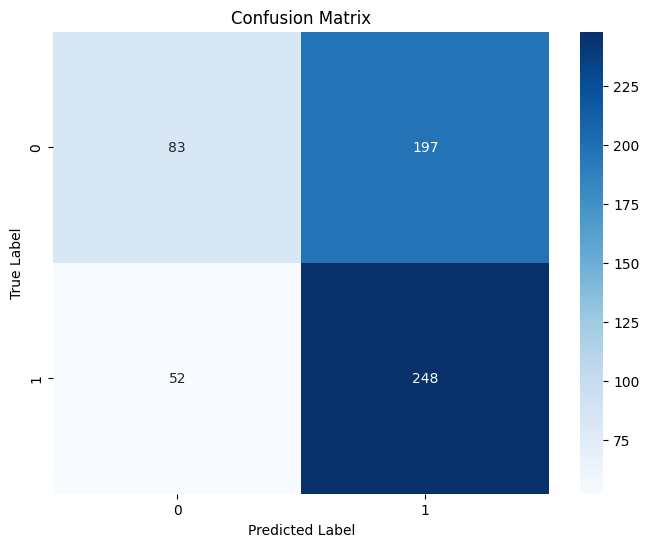

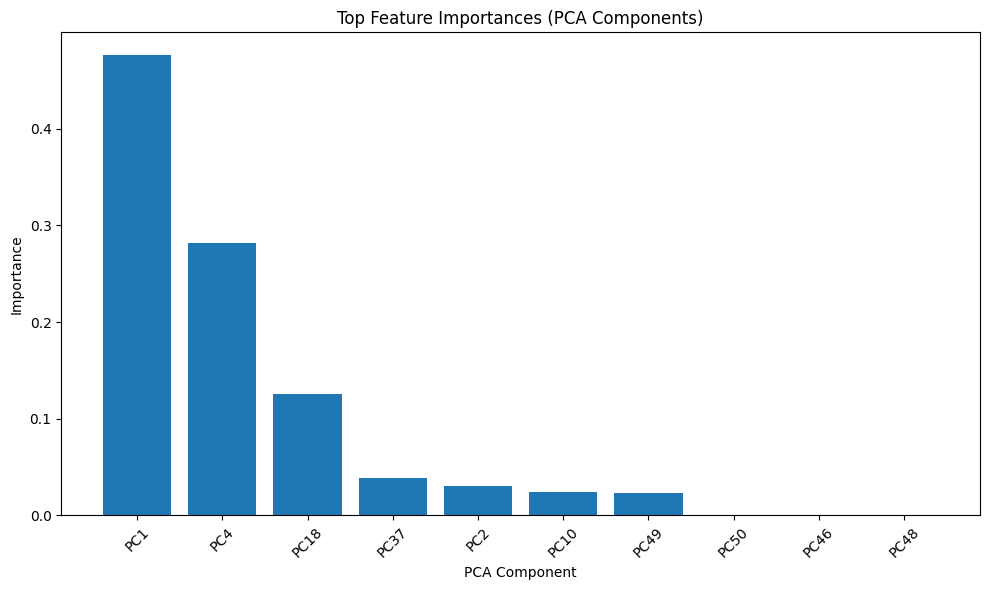

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import time
from scipy.stats import randint, uniform

# Setting random seed for reproducibility
np.random.seed(42)

# Loading and cleaning the dataset
def load_data():
    start_time = time.time()
    df = pd.read_csv('/content/IndicBERT_Malayalam_Embeddings.csv')

    print(f"Initial dataset shape: {df.shape}")
    print(f"NaN values in dataset: {df.isna().sum().sum()} total NaN values")
    print(f"NaN values in Label column: {df['Label'].isna().sum()}")

    df_clean = df.dropna()
    print(f"Dataset shape after dropping NaN values: {df_clean.shape}")

    X = df_clean.drop('Label', axis=1)
    y = df_clean['Label']

    print(f"Data loading completed in {time.time() - start_time:.2f} seconds")
    return X, y

# Applying PCA for dimensionality reduction
def apply_pca(X_train, X_test, n_components=50):
    start_time = time.time()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"Number of components selected: {pca.n_components_}")
    print(f"Explained variance ratio: {explained_variance:.4f}")
    print(f"PCA completed in {time.time() - start_time:.2f} seconds")

    return X_train_pca, X_test_pca, pca

# Performing hyperparameter tuning for AdaBoost
def tune_adaboost(X_train, y_train):
    start_time = time.time()
    estimator = DecisionTreeClassifier(random_state=42)
    adaboost = AdaBoostClassifier(estimator=estimator, random_state=42)

    param_dist = {
        'n_estimators': randint(50, 200),
        'learning_rate': uniform(0.01, 1.0),
        'estimator__max_depth': randint(1, 5),
        'estimator__min_samples_split': randint(2, 10),
        'estimator__min_samples_leaf': randint(1, 5)
    }

    random_search = RandomizedSearchCV(
        estimator=adaboost,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        n_jobs=-1,
        scoring='accuracy',
        verbose=1,
        random_state=42
    )

    random_search.fit(X_train, y_train)

    print("\nBest parameters:", random_search.best_params_)
    print("Best cross-validation score:", random_search.best_score_)
    print(f"Hyperparameter tuning completed in {time.time() - start_time:.2f} seconds")

    return random_search.best_estimator_

# Evaluating the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print("\nTraining Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_adaboost.png')

    print(f"Model evaluation completed in {time.time() - start_time:.2f} seconds")
    return train_accuracy, test_accuracy

# Visualizing feature importance
def plot_feature_importance(model, pca, n_features=10):
    start_time = time.time()
    importances = model.feature_importances_
    feature_names = [f'PC{i+1}' for i in range(len(importances))]
    indices = np.argsort(importances)[::-1][:n_features]

    plt.figure(figsize=(10, 6))
    plt.bar(range(n_features), importances[indices])
    plt.xticks(range(n_features), [feature_names[i] for i in indices], rotation=45)
    plt.title('Top Feature Importances (PCA Components)')
    plt.xlabel('PCA Component')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importance_adaboost.png')

    print(f"Feature importance plotting completed in {time.time() - start_time:.2f} seconds")

# Main execution
def main():
    start_time = time.time()
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test)
    best_adaboost = tune_adaboost(X_train_pca, y_train)
    train_acc, test_acc = evaluate_model(best_adaboost, X_train_pca, X_test_pca, y_train, y_test)
    plot_feature_importance(best_adaboost, pca)

    if test_acc >= 0.80:
        print("\nSuccess: Model achieved accuracy >= 80%")
    else:
        print("\nWarning: Model accuracy below 80%. Consider trying different parameters or models.")

    import joblib
    model_id = str(uuid.uuid4())
    joblib.dump(best_adaboost, f'adaboost_model_{model_id}.pkl')
    print(f"\nModel saved as adaboost_model_{model_id}.pkl")
    print(f"Total execution time: {time.time() - start_time:.2f} seconds")

if __name__ == "__main__":
    main()

Naive Bayes

Initial dataset shape: (2900, 769)
NaN values in dataset: 0 total NaN values
NaN values in Label column: 0
Dataset shape after dropping NaN values: (2900, 769)
Data loading completed in 0.90 seconds
Number of components selected: 50
Explained variance ratio: 0.9190
PCA completed in 1.23 seconds
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'var_smoothing': np.float64(0.05744851636320414)}
Best cross-validation score: 0.5818923107951058
Hyperparameter tuning completed in 0.45 seconds

Training Accuracy: 0.5862068965517241
Test Accuracy: 0.5741379310344827

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.61      0.33      0.42       280
           1       0.56      0.81      0.66       300

    accuracy                           0.57       580
   macro avg       0.59      0.57      0.54       580
weighted avg       0.59      0.57      0.55       580

Model evaluation completed in 0.26 seconds


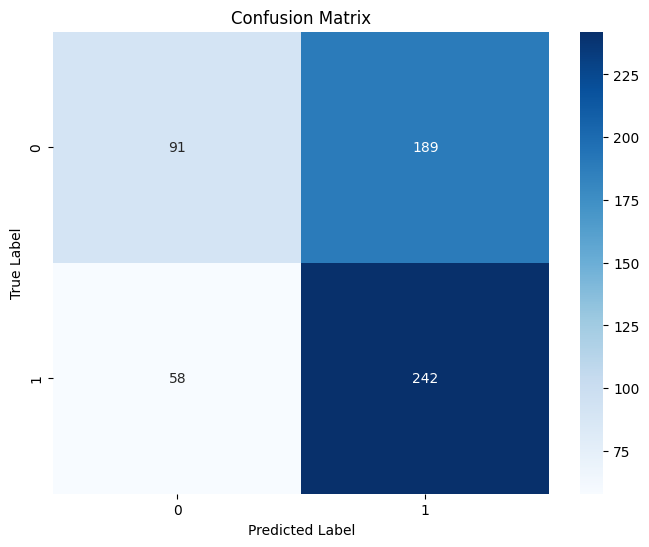

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import time
from scipy.stats import loguniform

# Setting random seed for reproducibility
np.random.seed(42)

# Loading and cleaning the dataset
def load_data():
    start_time = time.time()
    df = pd.read_csv('/content/IndicBERT_Malayalam_Embeddings.csv')

    print(f"Initial dataset shape: {df.shape}")
    print(f"NaN values in dataset: {df.isna().sum().sum()} total NaN values")
    print(f"NaN values in Label column: {df['Label'].isna().sum()}")

    df_clean = df.dropna()
    print(f"Dataset shape after dropping NaN values: {df_clean.shape}")

    X = df_clean.drop('Label', axis=1)
    y = df_clean['Label']

    print(f"Data loading completed in {time.time() - start_time:.2f} seconds")
    return X, y

# Applying PCA for dimensionality reduction
def apply_pca(X_train, X_test, n_components=50):
    start_time = time.time()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"Number of components selected: {pca.n_components_}")
    print(f"Explained variance ratio: {explained_variance:.4f}")
    print(f"PCA completed in {time.time() - start_time:.2f} seconds")

    return X_train_pca, X_test_pca, pca

# Performing hyperparameter tuning for Naive Bayes
def tune_naive_bayes(X_train, y_train):
    start_time = time.time()
    nb = GaussianNB()

    param_dist = {
        'var_smoothing': loguniform(1e-9, 1e-1)
    }

    random_search = RandomizedSearchCV(
        estimator=nb,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        n_jobs=-1,
        scoring='accuracy',
        verbose=1,
        random_state=42
    )

    random_search.fit(X_train, y_train)

    print("\nBest parameters:", random_search.best_params_)
    print("Best cross-validation score:", random_search.best_score_)
    print(f"Hyperparameter tuning completed in {time.time() - start_time:.2f} seconds")

    return random_search.best_estimator_

# Evaluating the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print("\nTraining Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_naive_bayes.png')

    print(f"Model evaluation completed in {time.time() - start_time:.2f} seconds")
    return train_accuracy, test_accuracy

# Main execution
def main():
    start_time = time.time()
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test)
    best_nb = tune_naive_bayes(X_train_pca, y_train)
    train_acc, test_acc = evaluate_model(best_nb, X_train_pca, X_test_pca, y_train, y_test)

    if test_acc >= 0.80:
        print("\nSuccess: Model achieved accuracy >= 80%")
    else:
        print("\nWarning: Model accuracy below 80%. Consider trying different parameters or models.")

    import joblib
    model_id = str(uuid.uuid4())
    joblib.dump(best_nb, f'naive_bayes_model_{model_id}.pkl')
    print(f"\nModel saved as naive_bayes_model_{model_id}.pkl")
    print(f"Total execution time: {time.time() - start_time:.2f} seconds")

if __name__ == "__main__":
    main()